## Data

We work with non-parallel voice conversion. This is more challenging but more valuable given that it s difficult to collect parallel training data of different speakers. 

There are two ways in which non-parallel data is handeled:
1. Convert it into parallel data and then learn mappining functions like 
    1.1 generatinf parallel data through test-to-speech synthesis 
    1.2 frame selection
    1.3 iterative combination of a nearest neighbor search step and a conversion stem alignment 
    1.4 CycleGAN based Voice conversion 
2. Factorize linguistic and speaker related representations carried by acoustic features 
    At conversion stage the linguistic content of the source speaker is tranformed to that of targer speaker 
    

References https://arxiv.org/pdf/1906.10508.pdf


We work with raw speech dataset

In [4]:
import pandas as pd       
import os 
import math 
import numpy as np
import matplotlib.pyplot as plt  
import IPython.display as ipd  # To play sound in the notebook
import librosa
import librosa.display
import os
os.chdir("/media/bithika/USB30FD/VCTK/VCTK-Corpus")

In [113]:
# PATHS 

raw_data = '/home/bithika/reSpeecher_voice_conversion/data/raw/VCTK-Corpus'


In [5]:
!ls

COPYING  NOTE  README  speaker-info.txt  txt


In [104]:
df = pd.read_csv("speaker-info.txt",delimiter= '\s+', index_col=False)
print(df.columns)
df.describe()

Index(['ID', 'AGE', 'GENDER', 'ACCENTS', 'REGION'], dtype='object')


,ID,AGE
count,108.000000,108.000000
mean,286.120370,22.666667
std,39.629763,3.013986
min,225.000000,18.000000
25%,253.750000,21.000000
50%,281.500000,22.000000
75%,313.250000,23.000000
max,376.000000,38.000000


In [107]:
df.head(10)

,ID,AGE,GENDER,ACCENTS,REGION
0,225,23,F,English,Southern-England
1,226,22,M,English,Surrey
2,227,38,M,English,Cumbria
3,228,22,F,English,Southern-England
4,229,23,F,English,Southern-England
5,230,22,F,English,Stockton-on-tees
6,231,23,F,English,Southern-England
7,232,23,M,English,Southern-England
8,233,23,F,English,Staffordshire
9,234,22,F,Scottish,WestDumfries


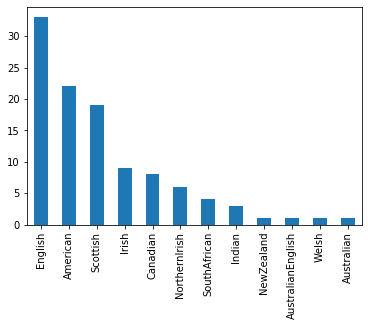

In [106]:
df['ACCENTS'].value_counts().plot(kind = 'bar')

This data contains a very low number of Indian accent English speakers, which in reality is different. 
Source: https://en.wikipedia.org/wiki/List_of_countries_by_English-speaking_population

## Preprocess data

In [118]:
import librosa
import numpy as np
import os, sys
import argparse
import pyworld
from multiprocessing import cpu_count
from concurrent.futures import ProcessPoolExecutor
from functools import partial
from utils import *
from tqdm import tqdm
from collections import defaultdict
from collections import namedtuple
from sklearn.model_selection import train_test_split
import glob
from os.path import join, basename
import subprocess

In [111]:
# Below is the accent information 
spk2acc = pd.Series(df.ACCENTS.values,index=df.ID).to_dict()
spk2acc

{225: 'English',
 226: 'English',
 227: 'English',
 228: 'English',
 229: 'English',
 230: 'English',
 231: 'English',
 232: 'English',
 233: 'English',
 234: 'Scottish',
 236: 'English',
 237: 'Scottish',
 238: 'NorthernIrish',
 239: 'English',
 240: 'English',
 241: 'Scottish',
 243: 'English',
 244: 'English',
 245: 'Irish',
 246: 'Scottish',
 247: 'Scottish',
 248: 'Indian',
 249: 'Scottish',
 250: 'English',
 251: 'Indian',
 252: 'Scottish',
 253: 'Welsh',
 254: 'English',
 255: 'Scottish',
 256: 'English',
 257: 'English',
 258: 'English',
 259: 'English',
 260: 'Scottish',
 261: 'NorthernIrish',
 262: 'Scottish',
 263: 'Scottish',
 264: 'Scottish',
 265: 'Scottish',
 266: 'Irish',
 267: 'English',
 268: 'English',
 269: 'English',
 270: 'English',
 271: 'Scottish',
 272: 'Scottish',
 273: 'English',
 274: 'English',
 275: 'Scottish',
 276: 'English',
 277: 'English',
 278: 'English',
 279: 'English',
 281: 'Scottish',
 282: 'English',
 283: 'Irish',
 284: 'Scottish',
 285: 'Scot

In [ ]:
min_length = 256   # Since we slice 256 frames from each utterance when training.
# Build a dict useful when we want to get one-hot representation of speakers.


In [140]:
import glob
# directories of audio files
data_dir = '/home/bithika/reSpeecher_voice_conversion/data/raw/VCTK-Corpus/wav48/'
audio_files = glob.glob(data_dir + '*.wav')

In [142]:
glob.glob(data_dir + '*.wav')

[]

In [127]:
import librosa
import numpy as np


class AudioLoader(object):

    @staticmethod
    def load(path, rate=16000, duration=None):
        raw, _ = librosa.load(path, rate, duration=duration)
        raw, _ = librosa.effects.trim(raw)
        raw /= np.abs(raw).max()
        raw = raw.astype(np.float32)
        return raw

In [128]:
raw_data

'/home/bithika/reSpeecher_voice_conversion/data/raw/VCTK-Corpus'

In [175]:

files = librosa.util.find_files(raw_data, ext=['wav']) 
files = np.asarray(files)


In [172]:
os.mkdir('/home/bithika/reSpeecher_voice_conversion/data/raw/interim')
os.mkdir('/home/bithika/reSpeecher_voice_conversion/data/interim/spectrogram/')

In [205]:
def create_fold_spectrograms():
    spectrogram_path ='/home/bithika/reSpeecher_voice_conversion/data/interim/spectrogram/' 
    audio_path = '/home/bithika/reSpeecher_voice_conversion/data/raw/VCTK-Corpus/wav48/'
    #print(f'Processing fold {fold}')
    #os.mkdir(os.path.join(spectrogram_path,fold))
    for audio_file in list(files):
        samples, sample_rate = librosa.load(audio_file)
        fig = plt.figure(figsize=[0.72,0.72])
        ax = fig.add_subplot(111)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        audio_name = audio_file.split('raw')[1].split('/')[-1].split('.')[0]
        filename  = spectrogram_path + audio_name + '.png'
        S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
        plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
        plt.close('all')
        

In [206]:
create_fold_spectrograms()

KeyboardInterrupt: 

In [ ]:
def resample(spk, origin_wavpath, target_wavpath):
    wavfiles = [i for i in os.listdir(join(origin_wavpath, spk)) if i.endswith(".wav")]
    for wav in wavfiles:
        folder_to = join(target_wavpath, spk)
        os.makedirs(folder_to, exist_ok=True)
        wav_to = join(folder_to, wav)
        wav_from = join(origin_wavpath, spk, wav)
        subprocess.call(['sox', wav_from, "-r", "16000", wav_to])
    return 0

def resample_to_16k(origin_wavpath, target_wavpath, num_workers=1):
    os.makedirs(target_wavpath, exist_ok=True)
    spk_folders = os.listdir(origin_wavpath)
    print(f"> Using {num_workers} workers!")
    executor = ProcessPoolExecutor(max_workers=num_workers)
    futures = []
    for spk in spk_folders:
        futures.append(executor.submit(partial(resample, spk, origin_wavpath, target_wavpath)))
    result_list = [future.result() for future in tqdm(futures)]
    print(result_list)

def split_data(paths):
    indices = np.arange(len(paths))
    test_size = 0.1
    train_indices, test_indices = train_test_split(indices, test_size=test_size, random_state=1234)
    train_paths = list(np.array(paths)[train_indices])
    test_paths = list(np.array(paths)[test_indices])
    return train_paths, test_paths

def get_spk_world_feats(spk_fold_path, mc_dir_train, mc_dir_test, sample_rate=16000):
    paths = glob.glob(join(spk_fold_path, '*.wav'))
    spk_name = basename(spk_fold_path)
    train_paths, test_paths = split_data(paths)
    f0s = []
    coded_sps = []
    for wav_file in train_paths:
        f0, _, _, _, coded_sp = world_encode_wav(wav_file, fs=sample_rate)
        f0s.append(f0)
        coded_sps.append(coded_sp)
    log_f0s_mean, log_f0s_std = logf0_statistics(f0s)
    coded_sps_mean, coded_sps_std = coded_sp_statistics(coded_sps)
    np.savez(join(mc_dir_train, spk_name+'_stats.npz'), 
            log_f0s_mean=log_f0s_mean,
            log_f0s_std=log_f0s_std,
            coded_sps_mean=coded_sps_mean,
            coded_sps_std=coded_sps_std)
    
    for wav_file in tqdm(train_paths):
        wav_nam = basename(wav_file)
        f0, timeaxis, sp, ap, coded_sp = world_encode_wav(wav_file, fs=sample_rate)
        normed_coded_sp = normalize_coded_sp(coded_sp, coded_sps_mean, coded_sps_std)
        np.save(join(mc_dir_train, wav_nam.replace('.wav', '.npy')), normed_coded_sp, allow_pickle=False)
    
    for wav_file in tqdm(test_paths):
        wav_nam = basename(wav_file)
        f0, timeaxis, sp, ap, coded_sp = world_encode_wav(wav_file, fs=sample_rate)
        normed_coded_sp = normalize_coded_sp(coded_sp, coded_sps_mean, coded_sps_std)
        np.save(join(mc_dir_test, wav_nam.replace('.wav', '.npy')), normed_coded_sp, allow_pickle=False)
    return 0


if __name__ == '__main__':
    parser = argparse.ArgumentParser()


    sample_rate_default = 16000
    origin_wavpath_default = "./data/VCTK-Corpus/wav48"
    target_wavpath_default = "./data/VCTK-Corpus/wav16"
    mc_dir_train_default = './data/mc/train'
    mc_dir_test_default = './data/mc/test'

    parser.add_argument("--sample_rate", type = int, default = 16000, help = "Sample rate.")
    parser.add_argument("--origin_wavpath", type = str, default = origin_wavpath_default, help = "The original wav path to resample.")
    parser.add_argument("--target_wavpath", type = str, default = target_wavpath_default, help = "The original wav path to resample.")
    parser.add_argument("--mc_dir_train", type = str, default = mc_dir_train_default, help = "The directory to store the training features.")
    parser.add_argument("--mc_dir_test", type = str, default = mc_dir_test_default, help = "The directory to store the testing features.")
    parser.add_argument("--num_workers", type = int, default = None, help = "The number of cpus to use.")

    argv = parser.parse_args()

    sample_rate = argv.sample_rate
    origin_wavpath = argv.origin_wavpath
    target_wavpath = argv.target_wavpath
    mc_dir_train = argv.mc_dir_train
    mc_dir_test = argv.mc_dir_test
    num_workers = argv.num_workers if argv.num_workers is not None else cpu_count()

    # The original wav in VCTK is 48K, first we want to resample to 16K
    resample_to_16k(origin_wavpath, target_wavpath, num_workers=num_workers)

    # WE only use 10 speakers listed below for this experiment.
    speaker_used = ['262', '272', '229', '232', '292', '293', '360', '361', '248', '251']
    speaker_used = ['p'+i for i in speaker_used]

    ## Next we are to extract the acoustic features (MCEPs, lf0) and compute the corresponding stats (means, stds). 
    # Make dirs to contain the MCEPs
    os.makedirs(mc_dir_train, exist_ok=True)
    os.makedirs(mc_dir_test, exist_ok=True)

    num_workers = len(speaker_used) #cpu_count()
    print("number of workers: ", num_workers)
    executor = ProcessPoolExecutor(max_workers=num_workers)

    work_dir = target_wavpath
    # spk_folders = os.listdir(work_dir)
    # print("processing {} speaker folders".format(len(spk_folders)))
    # print(spk_folders)

    futures = []
    for spk in speaker_used:
        spk_path = os.path.join(work_dir, spk)
        futures.append(executor.submit(partial(get_spk_world_feats, spk_path, mc_dir_train, mc_dir_test, sample_rate)))
    result_list = [future.result() for future in tqdm(futures)]
    print(result_list)
    sys.exit(0)

## Model

Language is inherently discrete, similarly speech is typically representated as a sequence of symbols. thus it makes sense to focus on Learning representation with discrete representations. 

VQVAE
pros: 
1. does not suffer from large variance 
2. avoids [posterior collapse](https://datascience.stackexchange.com/questions/48962/what-is-posterior-collapse-phenomenon)

VQ-VAE uses latent space in an effective manner: it can model important features which span many dimensions in data space (like phonemes in speech) as opposed to focusing or spending capacity on noise and imperceptible details which are oftern local

Lastly, once a good discrete latent structure of modality is discovered by VQ VAE we train a powerful prior over theses discrete random variables, which can yield interesting samples and useful applications 

When trained on speech one can discover latent structure of language without any supervision or prior knowledge about phonemes or words.  Furthermore we can equip decoder with the speaker identity which could allow for speaker conversion i.e transferrrinf voice from one speaker to another without changing contents. 


Main contribution of VQ VAE 
- when paired with a powerful proir, samples are coherent and hight quality speech generation
- their is some evidence of learning language through raw speech without any supervision and show applications of unsupervised speaker conversion

For speech one actually extracts 1D latent features 



https://blog.usejournal.com/understanding-vector-quantized-variational-autoencoders-vq-vae-323d710a888a

Ref [ELBO](https://medium.com/@hfdtsinghua/derivation-of-elbo-in-vae-25ad7991fdf7)


![Model](VQ_VAE.png)

In [3]:
import os
import warnings

import torch
import torchaudio
from torch.utils.data import Dataset
from torchaudio.datasets.utils import download_url, extract_archive, walk_files

URL = "http://homepages.inf.ed.ac.uk/jyamagis/release/VCTK-Corpus.tar.gz"
FOLDER_IN_ARCHIVE = "VCTK-Corpus"


def load_vctk_item(
    fileid, path, ext_audio, ext_txt, folder_audio, folder_txt, downsample=False
):
    speaker_id, utterance_id = fileid.split("_")

    # Read text
    file_txt = os.path.join(path, folder_txt, speaker_id, fileid + ext_txt)
    with open(file_txt) as file_text:
        utterance = file_text.readlines()[0]

    # Read wav
    file_audio = os.path.join(path, folder_audio, speaker_id, fileid + ext_audio)
    waveform, sample_rate = torchaudio.load(file_audio)
    if downsample:
        # TODO Remove this parameter after deprecation
        F = torchaudio.functional
        T = torchaudio.transforms
        # rate
        sample = T.Resample(sample_rate, 16000, resampling_method='sinc_interpolation')
        waveform = sample(waveform)
        # dither
        waveform = F.dither(waveform, noise_shaping=True)

    return waveform, sample_rate, utterance, speaker_id, utterance_id


class VCTK(Dataset):
    """
    Create a Dataset for VCTK. Each item is a tuple of the form:
    (waveform, sample_rate, utterance, speaker_id, utterance_id)
    """

    _folder_txt = "txt"
    _folder_audio = "wav48"
    _ext_txt = ".txt"
    _ext_audio = ".wav"

    def __init__(
        self,
        root,
        url=URL,
        folder_in_archive=FOLDER_IN_ARCHIVE,
        download=False,
        downsample=False,
        transform=None,
        target_transform=None,
    ):

        if downsample:
            warnings.warn(
                "In the next version, transforms will not be part of the dataset. "
                "Please use `downsample=False` to enable this behavior now, ",
                "and suppress this warning.",
                DeprecationWarning,
            )

        if transform is not None or target_transform is not None:
            warnings.warn(
                "In the next version, transforms will not be part of the dataset. "
                "Please remove the option `transform=True` and "
                "`target_transform=True` to suppress this warning.",
                DeprecationWarning,
            )

        self.downsample = downsample
        self.transform = transform
        self.target_transform = target_transform

        archive = os.path.basename(url)
        archive = os.path.join(root, archive)
        self._path = os.path.join(root, folder_in_archive)

        if download:
            if not os.path.isdir(self._path):
                if not os.path.isfile(archive):
                    download_url(url, root)
                extract_archive(archive)

        if not os.path.isdir(self._path):
            raise RuntimeError(
                "Dataset not found. Please use `download=True` to download it."
            )

        walker = walk_files(
            self._path, suffix=self._ext_audio, prefix=False, remove_suffix=True
        )
        self._walker = list(walker)

    def __getitem__(self, n):
        fileid = self._walker[n]
        item = load_vctk_item(
            fileid,
            self._path,
            self._ext_audio,
            self._ext_txt,
            self._folder_audio,
            self._folder_txt,
        )

        # TODO Upon deprecation, uncomment line below and remove following code
        # return item

        waveform, sample_rate, utterance, speaker_id, utterance_id = item
        if self.transform is not None:
            waveform = self.transform(waveform)
        if self.target_transform is not None:
            utterance = self.target_transform(utterance)
        return waveform, sample_rate, utterance, speaker_id, utterance_id

    def __len__(self):
        return len(self._walker)